学習データのシードを変化させて学習させ、結果得られたパラメータを観察したい

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import numpy as np
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import statsmodels.api as sm
from scipy.stats import norm

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [2]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
# フォルダを作成（既にあるならそれで良し）
os.makedirs("output-images", exist_ok=True)
os.makedirs("images", exist_ok=True)
os.makedirs("parameters", exist_ok=True)

In [22]:
# 学習時のハイパラの決定（入力を受け付ける）
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20000, help="学習させる回数")
parser.add_argument("--network_seed", type=int, default=0, help="networkのパラメータの初期値のシード")
parser.add_argument("--random_seed", type=int, default=0, help="訓練データの時系列のどの時刻を学習に用いるかをランダムに決定する時のシード")
parser.add_argument("--batch_size", type=int, default=64, help="batchの大きさ")
parser.add_argument("--lr", type=float, default=0.00005, help="学習率")
parser.add_argument("--sample_interval", type=int, default=1000, help="batchを何回学習させる度にgeneratorの出力を保存するか")
parser.add_argument("--network_bias", type=bool, default=False, help="networkにbiasを入れるかどうか。True/False")
parser.add_argument("--data_seed", type=int, default=0, help="Dataの作成に用いる乱数のseed True/False")
# opt = parser.parse_args()
opt = parser.parse_args(args=[])


opt.network_bias=True

In [6]:
p=7

In [23]:
opt.data_seed

0

/home/lab/ryuichi/.pyenv/versions/anaconda3-4.3.1/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


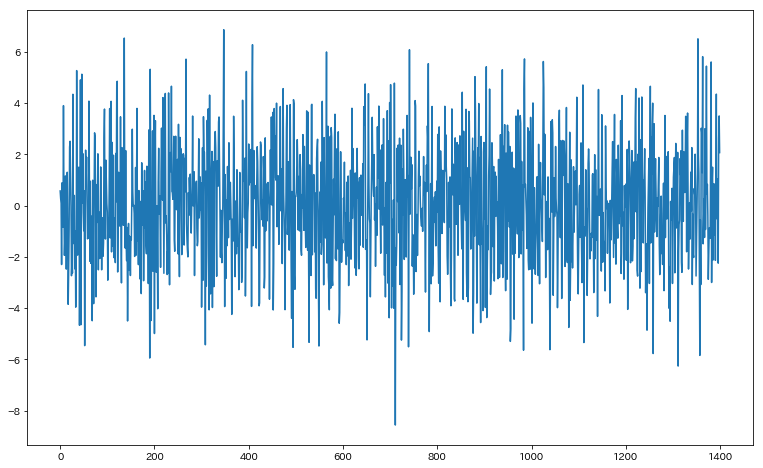

In [24]:
Data = tsModel.SARIMA(a=[0.3,-0.4,0.3,-0.4,0.3,-0.4,0.3], N=1400, random_seed=opt.data_seed, sigma=2)
Data = torch.tensor(Data, dtype=torch.float)
Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
plt.savefig("images/AR7モデルの人工データその{0}.png".format(opt.data_seed))
plt.show()

In [11]:
Data=Data.view(1,-1)
trainData = Data[:,:1000]
valData = Data[:,1000:1200]
testData = Data[:,1200:]

In [12]:
trainMatrix = []
for i in range(trainData.shape[1]-(p+1)):
    ans = trainData[:,i:i+p+1].view(1,Data.shape[0],-1)
    trainMatrix.append(ans)
trainMatrix = torch.cat(trainMatrix)
trainMatrix.shape

torch.Size([992, 1, 8])

In [13]:
valMatrix = []
for i in range(valData.shape[1]-(p+1)):
    ans = valData[:,i:i+p+1].view(1,Data.shape[0],-1)
    valMatrix.append(ans)
valMatrix = torch.cat(valMatrix)
valMatrix.shape

torch.Size([192, 1, 8])

In [14]:
torch.manual_seed(opt.network_seed)
net = models.LinearPredictNet(p = p, input_dim=1, is_bias=opt.network_bias)

In [15]:
# gpuが使えるかどうか
cuda = True if torch.cuda.is_available() else False
if cuda:
    print("GPUが使えます。")
    use_gpu = input('GPUを使いますか？ （Yes：1, No：0）  ----> ')
    cuda = bool(int(use_gpu))
else:
    print("GPUは使えません。")
    
if cuda:
    gpu_id = input('使用するGPUの番号を入れてください : ')
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
device = torch.device('cuda:'+gpu_id if cuda else 'cpu')

GPUが使えます。
GPUを使いますか？ （Yes：1, No：0）  ----> 0


In [16]:
# Optimizers(パラメータに対して定義される)
optimizer = torch.optim.RMSprop(net.parameters(), lr=opt.lr)

In [17]:
# パラメータと学習データをGPUに乗っける
net.to(device)

trainMatrix=trainMatrix.to(device)
valMatrix=valMatrix.to(device)

In [18]:
saveModel = input('作成したモデルを保存しますか？ （Yes：1, No：0）  ----> ')
saveModel = bool(int(saveModel))

作成したモデルを保存しますか？ （Yes：1, No：0）  ----> 0


In [19]:
import japanize_matplotlib
from scipy.stats import gaussian_kde

In [20]:
train_loss_curve = []
val_loss_curve = []

for epoch in range(1, opt.n_epochs+1):# epochごとの処理
    for i, batch in enumerate(range(0, trainMatrix.shape[0]-opt.batch_size, opt.batch_size)):# batchごとの処理
        
        # generatorへの入力を用意する
        X = trainMatrix[batch:batch+opt.batch_size]# torch.Size([64, 1, 8])
        # 時系列の順番はそのまま入力した方がいいのかな？
        rand=random.randint(0,trainMatrix.shape[0] - trainMatrix.shape[0]// opt.batch_size*opt.batch_size)
        X = trainMatrix[batch+rand : batch+rand+opt.batch_size]# torch.Size([64, 1, 8])
    
        
        input_tensor = X[:,:,0:p]
        true_tensor = X[:,:,p:p+1].view(opt.batch_size, -1)
        input_tensor = torch.cat([input_tensor, torch.randn([opt.batch_size,1,1]).to(device)], dim=2)
        input_tensor = Variable(input_tensor)
        
        Loss = nn.MSELoss()
        output_tensor = net(input_tensor)
        loss = Loss(output_tensor, true_tensor)

        loss.backward()
        optimizer.step()
    
    train_loss_curve.append(loss.item())
    
    val_input = torch.cat([valMatrix[:,:,0:p], torch.randn([valMatrix.shape[0],1,1]).to(device)], dim=2)
    val_target = valMatrix[:,:,p:p+1].view(valMatrix.shape[0], -1)
    val_loss = Loss(net(val_input), val_target)
    
    val_loss_curve.append(val_loss.item())
    
    if saveModel:
        if epoch%opt.sample_interval==0:
            torch.save(net.state_dict(), 'parameters/network_epoch{0}_{1}_batchSize{2}_networkSeed{3}_p{4}_networkBias{5}_dataSeed{6}.pth'.format(epoch, opt.n_epochs, opt.batch_size, opt.network_seed, p, opt.network_bias, opt.data_seed))

        
    
    if epoch%opt.sample_interval==0 or epoch==opt.n_epochs:
        plt.figure(figsize=(13,8))
        plt.title("Lossの遷移　\n　epoch:{0}, batchSize:{2}, network initial Seed:{3}, p:{4}, bias:{5}, data Seed:{6}".format(epoch, opt.n_epochs, opt.batch_size, opt.network_seed, p, opt.network_bias, opt.data_seed))
        plt.xlabel("epoch")
        plt.ylabel("Loss")
        plt.plot(train_loss_curve, label="training")
        plt.plot(val_loss_curve, label="validation")
        plt.legend()
        plt.savefig("loss.png")
        plt.show()
    
    print("[Epoch %d/%d] [train loss: %f] [validation loss: %f]" % (epoch, opt.n_epochs,loss.item(), val_loss.item()))


[Epoch 1/20000] [train loss: 9.373260] [validation loss: 5.789288]
[Epoch 2/20000] [train loss: 8.590399] [validation loss: 5.791484]
[Epoch 3/20000] [train loss: 6.792934] [validation loss: 5.612645]
[Epoch 4/20000] [train loss: 7.356492] [validation loss: 5.773359]
[Epoch 5/20000] [train loss: 9.114754] [validation loss: 5.563453]
[Epoch 6/20000] [train loss: 9.422600] [validation loss: 5.634809]
[Epoch 7/20000] [train loss: 8.767122] [validation loss: 5.660743]
[Epoch 8/20000] [train loss: 7.407011] [validation loss: 5.437670]
[Epoch 9/20000] [train loss: 8.739031] [validation loss: 5.561789]
[Epoch 10/20000] [train loss: 6.623893] [validation loss: 5.571431]
[Epoch 11/20000] [train loss: 8.746415] [validation loss: 5.491060]
[Epoch 12/20000] [train loss: 9.066630] [validation loss: 5.387135]
[Epoch 13/20000] [train loss: 8.726299] [validation loss: 5.456070]
[Epoch 14/20000] [train loss: 8.954132] [validation loss: 5.559680]
[Epoch 15/20000] [train loss: 7.371519] [validation loss:

[Epoch 135/20000] [train loss: 6.993047] [validation loss: 4.539386]
[Epoch 136/20000] [train loss: 5.749375] [validation loss: 4.466771]
[Epoch 137/20000] [train loss: 7.054752] [validation loss: 4.550253]
[Epoch 138/20000] [train loss: 5.977052] [validation loss: 4.498425]
[Epoch 139/20000] [train loss: 7.178581] [validation loss: 4.492347]
[Epoch 140/20000] [train loss: 6.860288] [validation loss: 4.469209]
[Epoch 141/20000] [train loss: 7.135589] [validation loss: 4.508725]
[Epoch 142/20000] [train loss: 5.523582] [validation loss: 4.390183]
[Epoch 143/20000] [train loss: 7.011772] [validation loss: 4.553077]
[Epoch 144/20000] [train loss: 5.801959] [validation loss: 4.377890]
[Epoch 145/20000] [train loss: 5.989789] [validation loss: 4.424385]
[Epoch 146/20000] [train loss: 5.455249] [validation loss: 4.397219]
[Epoch 147/20000] [train loss: 7.071338] [validation loss: 4.517388]
[Epoch 148/20000] [train loss: 5.538662] [validation loss: 4.456905]
[Epoch 149/20000] [train loss: 5.8

[Epoch 275/20000] [train loss: 5.369527] [validation loss: 3.989623]
[Epoch 276/20000] [train loss: 5.400497] [validation loss: 3.975893]
[Epoch 277/20000] [train loss: 4.927485] [validation loss: 4.007602]
[Epoch 278/20000] [train loss: 5.037582] [validation loss: 4.000247]
[Epoch 279/20000] [train loss: 4.762973] [validation loss: 3.992429]
[Epoch 280/20000] [train loss: 4.867016] [validation loss: 3.982469]
[Epoch 281/20000] [train loss: 4.753814] [validation loss: 3.983696]
[Epoch 282/20000] [train loss: 5.999470] [validation loss: 3.995850]
[Epoch 283/20000] [train loss: 5.899418] [validation loss: 3.975655]
[Epoch 284/20000] [train loss: 5.340206] [validation loss: 3.984124]
[Epoch 285/20000] [train loss: 5.780739] [validation loss: 4.009709]
[Epoch 286/20000] [train loss: 5.788733] [validation loss: 3.977080]
[Epoch 287/20000] [train loss: 5.012255] [validation loss: 3.984098]
[Epoch 288/20000] [train loss: 4.884576] [validation loss: 3.980024]
[Epoch 289/20000] [train loss: 5.7

[Epoch 415/20000] [train loss: 5.071979] [validation loss: 3.704927]
[Epoch 416/20000] [train loss: 5.143750] [validation loss: 3.722018]
[Epoch 417/20000] [train loss: 5.088584] [validation loss: 3.736770]
[Epoch 418/20000] [train loss: 5.084740] [validation loss: 3.715902]
[Epoch 419/20000] [train loss: 4.410242] [validation loss: 3.737592]
[Epoch 420/20000] [train loss: 5.098873] [validation loss: 3.695667]
[Epoch 421/20000] [train loss: 5.100999] [validation loss: 3.736021]
[Epoch 422/20000] [train loss: 5.202763] [validation loss: 3.709320]
[Epoch 423/20000] [train loss: 4.990492] [validation loss: 3.741327]
[Epoch 424/20000] [train loss: 4.798429] [validation loss: 3.725031]
[Epoch 425/20000] [train loss: 5.083865] [validation loss: 3.736459]
[Epoch 426/20000] [train loss: 5.003397] [validation loss: 3.722436]
[Epoch 427/20000] [train loss: 4.317356] [validation loss: 3.703849]
[Epoch 428/20000] [train loss: 4.216337] [validation loss: 3.695496]
[Epoch 429/20000] [train loss: 5.1

[Epoch 554/20000] [train loss: 4.159607] [validation loss: 3.696079]
[Epoch 555/20000] [train loss: 3.601030] [validation loss: 3.803231]
[Epoch 556/20000] [train loss: 4.470884] [validation loss: 3.702686]
[Epoch 557/20000] [train loss: 4.592777] [validation loss: 3.682923]
[Epoch 558/20000] [train loss: 3.946327] [validation loss: 3.659252]
[Epoch 559/20000] [train loss: 3.893353] [validation loss: 3.721074]
[Epoch 560/20000] [train loss: 4.684783] [validation loss: 3.692069]
[Epoch 561/20000] [train loss: 4.642984] [validation loss: 3.775563]
[Epoch 562/20000] [train loss: 3.911984] [validation loss: 3.717146]
[Epoch 563/20000] [train loss: 3.700587] [validation loss: 3.754664]
[Epoch 564/20000] [train loss: 4.009356] [validation loss: 3.798337]
[Epoch 565/20000] [train loss: 4.135839] [validation loss: 3.727775]
[Epoch 566/20000] [train loss: 3.479618] [validation loss: 3.724800]
[Epoch 567/20000] [train loss: 4.611531] [validation loss: 3.805427]
[Epoch 568/20000] [train loss: 4.1

KeyboardInterrupt: 

In [21]:
torch.save(net.state_dict(), 'parameters/network_epoch{1}_batchSize{2}_networkSeed{3}_p{4}_networkBias{5}_dataSeed{6}.pth'.format(epoch, opt.n_epochs, opt.batch_size, opt.network_seed, p, opt.network_bias, opt.data_seed))


In [ ]:
plt.figure(figsize=(13,8))
plt.title("Lossの遷移　\n　epoch:{1}, batchSize:{2}, network initial Seed:{3}, p:{4}, bias:{5}, data Seed:{6}".format(epoch, opt.n_epochs, opt.batch_size, opt.network_seed, p, opt.network_bias, opt.data_seed))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(train_loss_curve, label="training")
plt.plot(val_loss_curve, label="validation")
plt.legend()
plt.savefig("output-images/loss_epoch{1}_batchSize{2}_networkSeed{3}_p{4}_networkBias{5}_dataSeed{6}.png".format(epoch, opt.n_epochs, opt.batch_size, opt.network_seed, p, opt.network_bias, opt.data_seed))
plt.show()